In [1]:
# MLP

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
fpath = "../../data/DNN_data/v1/"

sig_with_artifact = np.load(fpath + "data_signal_with_sine" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


Text(0.5, 1.0, 'Original Signal')

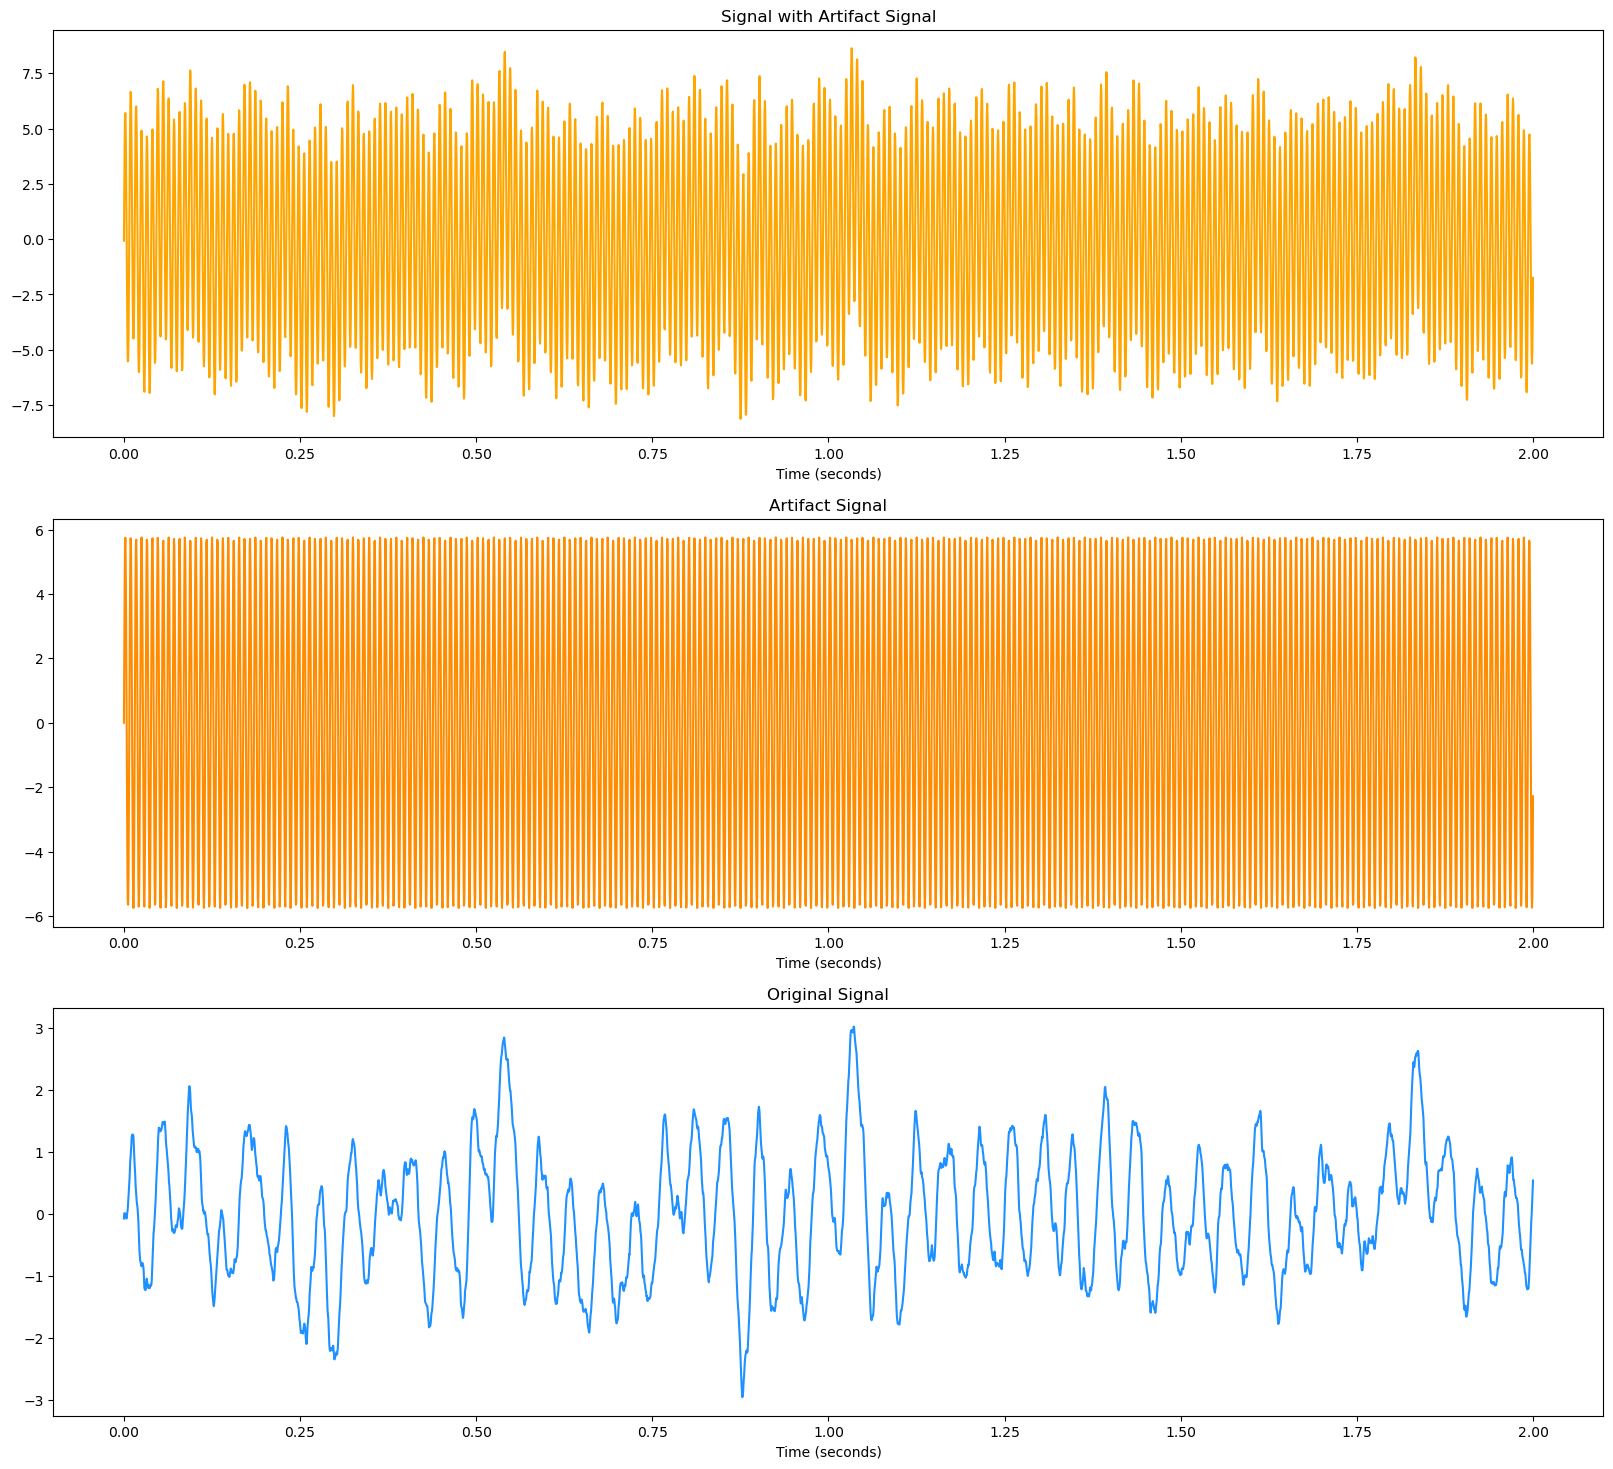

In [4]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,18))
plt.subplot(3, 1, 1)
plt.plot(t, sig_with_artifact[0], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t, artifact[0], color='darkorange')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t, sig[0], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

(1000, 4000)
(1000, 4000)


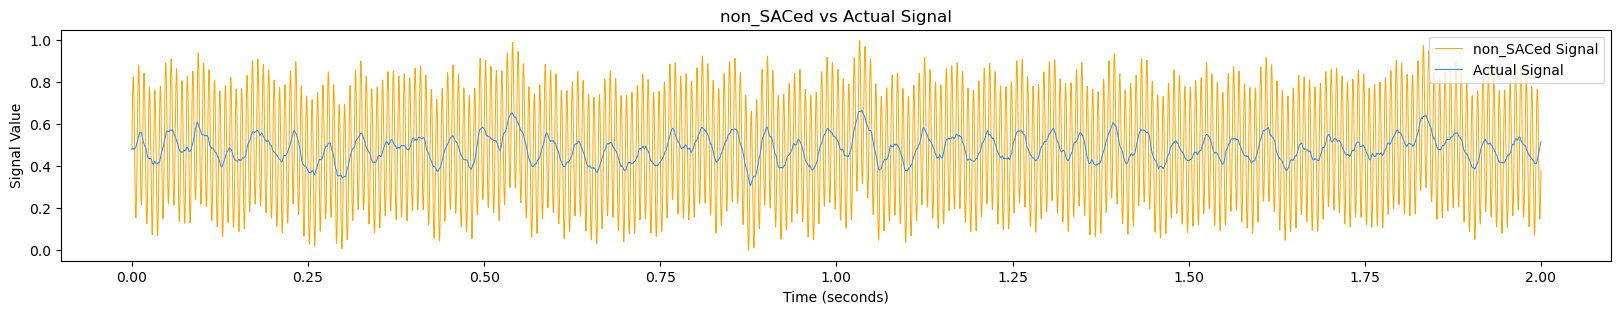

In [5]:
# min-max normalization

X = (sig_with_artifact - np.min(sig_with_artifact, axis=1).reshape(-1, 1)) / (np.max(sig_with_artifact, axis=1).reshape(-1, 1) - np.min(sig_with_artifact, axis=1).reshape(-1, 1))
y = (sig - np.min(sig_with_artifact, axis=1).reshape(-1, 1)) / (np.max(sig_with_artifact, axis=1).reshape(-1, 1) - np.min(sig_with_artifact, axis=1).reshape(-1, 1))

print(X.shape)
print(y.shape) 

plt.figure(figsize=(20, 3))
plt.plot(t, X[0,:], label='non_SACed Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(t, y[0,:], label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('non_SACed vs Actual Signal')
plt.legend()
plt.show()

In [6]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# 차원 추가 (MLP는 마지막 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 4000, 1) # B x T x 1
X_test = X_test.reshape(X_test.shape[0], 4000, 1)

print("unsqueezed X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T x 1, y : B x T
print("unsqueezed X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 4000), y_train shape: (800, 4000)
X_test shape: (200, 4000), y_test shape: (200, 4000)
unsqueezed X_train shape: (800, 4000, 1), y_train shape: (800, 4000)
unsqueezed X_test shape: (200, 4000, 1), y_test shape: (200, 4000)


In [7]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=256) 
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=1)

    def forward(self, input_data): # x : B x T x 1
        x = F.relu(self.fc1(input_data)) # x : B x T x 256
        x = self.drop(x)
        x = F.relu(self.fc2(x)) # x : B x T x 128
        x = self.drop(x)
        x = F.relu(self.fc3(x)) # x : B x T x 64
        x = self.drop(x)
        x = self.fc4(x).squeeze(-1) # x : B x T x 1 -> x : B x T
        return x

model = MLP().to(device)
print(model)


MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [8]:
# 모델 학습
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 5/200, Loss: 0.007733299396932125
Epoch 10/200, Loss: 0.006315251812338829
Epoch 15/200, Loss: 0.005501228384673595
Epoch 20/200, Loss: 0.004968647379428148
Epoch 25/200, Loss: 0.004709695000201464
Epoch 30/200, Loss: 0.004411408212035894
Epoch 35/200, Loss: 0.004254747647792101
Epoch 40/200, Loss: 0.004076724871993065
Epoch 45/200, Loss: 0.003921629395335913
Epoch 50/200, Loss: 0.0038100103847682476
Epoch 55/200, Loss: 0.003698250511661172
Epoch 60/200, Loss: 0.003556485753506422
Epoch 65/200, Loss: 0.0034130727872252464
Epoch 70/200, Loss: 0.0033749358262866735
Epoch 75/200, Loss: 0.0033172022085636854
Epoch 80/200, Loss: 0.0031804111786186695
Epoch 85/200, Loss: 0.0032585843000561
Epoch 90/200, Loss: 0.003060954622924328
Epoch 95/200, Loss: 0.003099489491432905
Epoch 100/200, Loss: 0.0030460054986178875
Epoch 105/200, Loss: 0.0030330668669193983
Epoch 110/200, Loss: 0.0029547479934990406
Epoch 115/200, Loss: 0.0030030859634280205
Epoch 120/200, Loss: 0.0030197445303201675
Epoc

In [9]:
# 모델 평가
non_SACed = torch.tensor([])
gt = torch.tensor([])
pred = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T
        
        non_SACed = torch.cat((non_SACed, x.squeeze().cpu()), 0)
        pred = torch.cat((pred, y_pred.cpu()), 0)
        gt = torch.cat((gt, y.cpu()), 0)

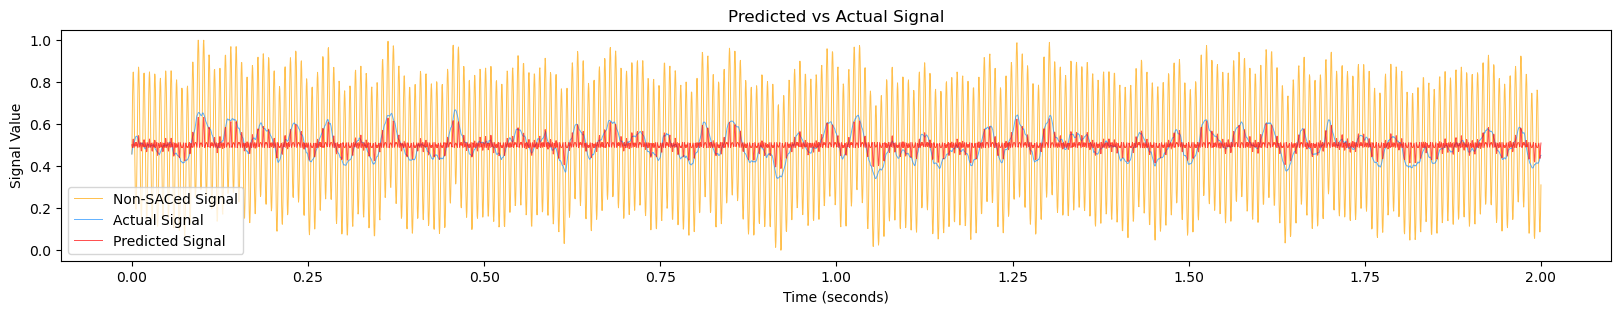

Mean Absolute Error: 0.04233555495738983
Mean Squared Error: 0.002910663140937686


In [10]:
# time domain plotting
non_SACed_signal = non_SACed[0]
predicted_signal = pred[0]
actual_signal = gt[0]  

plt.figure(figsize=(20, 3))
plt.plot(t, non_SACed_signal, label='Non-SACed Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, actual_signal, label='Actual Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, predicted_signal, label='Predicted Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

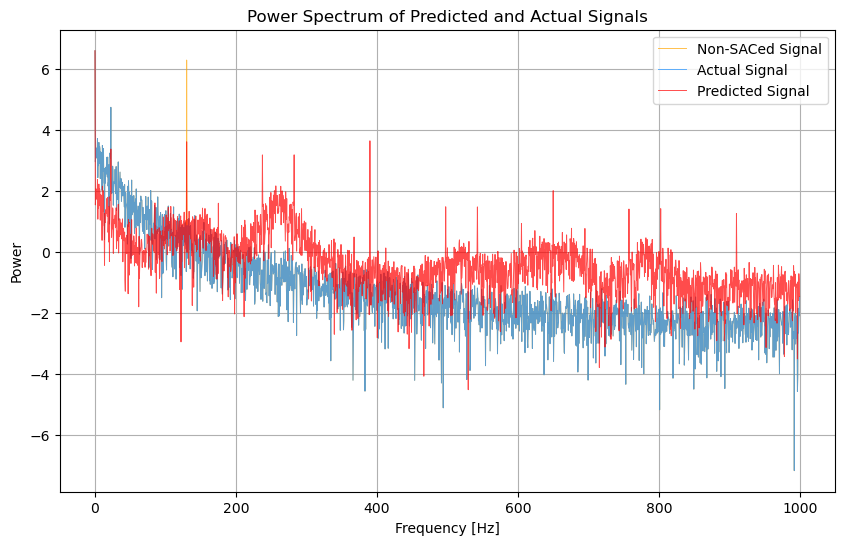

Mean Absolute Error: 1.2641363551446843
Mean Squared Error: 2.2396722165937595


In [11]:
# frequency domain plotting

n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

fft_nonSACed = np.fft.fft(non_SACed_signal)
fft_nonSACed = np.abs(fft_nonSACed[:n//2])
fft_nonSACed[1:] = 2 * fft_nonSACed[1:]
power_nonSACed = fft_nonSACed**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_nonSACed), label='Non-SACed Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")